In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import shapely.geometry as geometry
import shapely.ops as so
from Dynamic import DynamicMap
from Camera import Camera
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.spatial import KDTree
import json

In [2]:
# Position
map_size = [30, 20]
x0 = [5, 5, 0]
xf = [25, 5, 100]
# xf = [15, 17.5, 1000]
# static_obstacle_position: [anchor point, width, height]
static_obstacle_pos = [[[10, 0], 10, 15]]
dynamic_obstacle_pos = [[10, 15], [20, 15]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
iter_max = 1000
tMax = 100
vmax = 2.5
max_time = 5

In [3]:
tilt_limit = np.array([[np.deg2rad(0), np.deg2rad(180)], [np.deg2rad(0), np.deg2rad(180)]]) #[upper, lower]
fov_ang = np.deg2rad(30)
fov_rng = 7.5
panSpeed = [-np.deg2rad(5), np.deg2rad(2)]

In [4]:
# Test case
# Vehicle Spec
vehicle = {}
vehicle['v'] = 2
vehicle['radius'] = 0.5
t = [200, .25, 500]

# Map
map_in = {}
# Static Map
map_in['st'] = {}
map_in['st']['size'] = np.array([0, 30, 0, 20])
# Single buliding example
map_in['st']['n'] = 1
map_in['st']['0'] = np.array([(10,0), (10,15), (20,15), (20,0)])

# Dynamic Map
# This is a continuous function generates camera FOV coverages
# Input is map_in, and time input t_in
map_in['n'] = t[0]

# Single camera example, surveying final location xfin
# Camera Position
cam_x = np.array([10, 20])
cam_y = np.array([15, 15])
cam_dict = {}
cam_dict['n'] = len(cam_x)
map_in['ncam'] = len(cam_x)
cam_dict['x'] = cam_x
cam_dict['y'] = cam_y

# Camera Spec
cam_period = t[0]
cam_increment = t[1]
cam_dict['spec'] = {}
cam_dict['spec']['init_angle'] = [np.deg2rad(180), np.deg2rad(0)]
cam_dict['spec']['bound'] = tilt_limit
cam_dict['spec']['fov'] = [fov_ang, fov_rng]
cam_dict['spec']['cam_time'] = [cam_period, cam_increment]
cam_dict['spec']['panspeed'] = panSpeed

# Test dynamic map
dmap = DynamicMap(map_in, cam_dict)
map_in['dy'] = dmap

2D Space-Time RRT*

In [5]:
def distance_RRTstar(a, b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [6]:
def random_sample_RRTstar():
    n = 1
    trand = rn.uniform(0, 250)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        xrand = xf[0]
        yrand = xf[1]
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0[0], 0]
        point2 = [0, x0[0]/vmax]
        point3 = [map_size[0], (map_size[0]-x0[0])/vmax]
        # point4 = [0, (map_size[0]-x0[0])/vmax]
        point4 = [0, trand]
        point5 = [map_size[0], trand]
        pos = [point1, point2, point3, point4, point5]

        # Convex hull
        hull = ConvexHull( pos )
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
        # yrand = rn.uniform(-vmax/2*(trand - 1/vmax*(xf[0]+x0[0])), vmax/2*(trand - 1/vmax*(xf[0]+x0[0])))
        yrand = rn.uniform(np.min([0, x0[0]/vmax]), np.min([vmax*(trand+x0[0]/vmax), map_size[1]]))
    return [xrand, yrand, trand]

In [7]:
def reachable_RRTstar(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dy = np.abs(q1[1]-q0[1])
    dd = np.sqrt(dx**2 + dy**2)
    dt = q1[2]-q0[2]

    if dt > 0 and dd/dt <= vmax:
        return True
    else:
        return False

In [8]:
def find_neighbor_RRTstar(qrand, V):
    # Find Neighbor
    dist_vec = []
    for vi in V:
        if reachable_RRTstar(vi, qrand):
            dist_vec.append(distance_RRTstar(vi, qrand))
        else:
            dist_vec.append(1e1000)
    if len(dist_vec) > 0:
        closestIndex = dist_vec.index(min(dist_vec))
        qclosest = V[closestIndex]
        return qclosest
    else:
        return None

In [9]:
def extend_RRTstar(q0, q1, max_time):
    dx = q1[0]-q0[0]
    dy = q1[1]-q0[1]
    dt = q1[2]-q0[2]
    max_distance = max_time

    if np.abs(dx)<=max_distance and \
       np.abs(dy)<=max_distance and \
       np.abs(dt)<=max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2+dy**2+dt**2)
        dxnorm = dx/norm*vmax
        dynorm = dy/norm*vmax
        dtnorm = dt/norm*vmax
        qnew = [q0[0]+dxnorm, q0[1]+dynorm, q0[2]+dtnorm]
    return qnew

In [10]:
def validate_RRTstar(q):
    # True:  No violation
    # False: Violation detected
    tGiven = q[2]
    qpoint = Point(q[0], q[1])

    checkInMap = []
    # Check for map
    # Check if x coordinate is OK
    if q[0] >= 0 and q[0] <= map_size[0]:
        # Check if y coordinate is OK
        if q[1] >= 0 and q[1] <= map_size[1]:
            checkInMap = False
        else:
            checkInMap = True
    else:
        checkInMap = True
    
    checkStatic = []
    # Check for static
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(static_polygon.contains(qpoint))

    checkDynamic = []
    # Check for dynamic
    for i in range(cam_dict['n']):
        cameras = dmap.gen_cam(i, tGiven)
        cam_i = cameras[str(i)]['FOV_Poly']
        checkDynamic.append(cam_i.contains(geometry.Point(q[0],q[1])))

    return not (bool(checkInMap) and bool(np.sum(checkStatic)) and bool(np.sum(checkDynamic)))

In [11]:
def check_route_RRTstar(q1, q2):
    route_check = []
    line = geometry.LineString([q1, q2])

    checkStatic = []
    #check for static
    # False: No collision
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(line.intersects(static_polygon))

    checkDynamic = []
    # check for dynamic
    # False: No collision
    timeVectorToCheck = np.linspace(q1[2], q2[2], 101)
    for tGiven in timeVectorToCheck:
        for i in range(cam_dict['n']):
            # TODO
            # get FOV and check geometric containment
            cameras = dmap.gen_cam(i, tGiven)
            cam_i = cameras[str(i)]['FOV_Poly']
            checkDynamic.append(line.intersects(cam_i))
            
    # True: No collision
    # False: Collison
    if not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))):
        # Collison-free
        return True
    else:
        return False


In [12]:
def find_neighbors_proximity_RRTstar(prox, q, V):
    output = []
    for v in V:
        if 0 <= q[0]-v[0] <= prox and \
            0 <= q[1]-v[1] <= prox:
            output.append(v)
    return output

In [13]:
def find_path_RRTstar(xf, E):
    path = []
    path.append(E[-1][1])
    currentNode = E[-1][1]
    iter = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if currentNode[0]==e[0] and \
                currentNode[1]==e[1] and \
                currentNode[2]==e[2]:
                currentNode = E[ei][0]
                path.append(currentNode)
                break
        iter += 1
        if currentNode[0]==x0[0] and \
            currentNode[1]==x0[1] and \
            currentNode[2]==0:
            return path

In [14]:
"""Standard RRT* in 2D Space-Time"""
def standard_2D_RRTstar(compTimeLimit):
    time_vec = []
    RRT_total_time = []
    RRT_total_distance = []
    succeed_trials = 0

    start = time.time()
    k = 0
    V_RRT = []
    V_RRT.append([x0[0], x0[1], 0])
    T_RRT = []
    T_RRT.append(0)
    E_RRT = []

    path_RRT = None
    while 1:
        while 1:
            if time.time()-start > compTimeLimit:
                break
            qrand = random_sample_RRTstar()
            qclosest = find_neighbor_RRTstar(qrand, V_RRT)
            
            if time.time()-start > compTimeLimit:
                break
            
            if qclosest is not None:
                qnew = extend_RRTstar(qclosest, qrand, max_time)
                if time.time()-start > compTimeLimit:
                    break
                # Validate
                validationCheck = validate_RRTstar(qnew)
                if validationCheck is True and check_route_RRTstar(qclosest, qrand) is True:
                    break
        if time.time()-start > compTimeLimit:
            break
        k += 1
        V_RRT.append(qnew)
        E_RRT.append([qclosest, qnew])
        T_RRT.append(qnew[2])
        if time.time()-start > compTimeLimit:
            break

        # Rewiring
        if k > 1:
            qmin = qclosest
            cost_old = distance_RRTstar(qclosest, qnew)
            neighbor_vector = find_neighbors_proximity_RRTstar(2.5, qnew, V_RRT)
            if len(neighbor_vector) > 0:
                for v in neighbor_vector:
                    if cost_old + distance_RRTstar(v, qnew) < distance_RRTstar(qclosest, v) and \
                        check_route_RRTstar(v, qnew):
                        cost_old = cost_old + distance_RRTstar(v, qnew)
                        qmin = v
                E_RRT.append([qnew, qmin])

        if time.time()-start > compTimeLimit:
            break

        # Check to continue:
        distanceCheck = []
        if np.abs(distance_RRTstar(xf, qnew)) <= 1e-2:
            distanceCheck.append(1)
        else:
            distanceCheck.append(0)

        if time.time()-start > compTimeLimit:
            break

        if np.sum(distanceCheck) > 0:
            distanceToXf = distance_RRTstar(xf, qnew)
            qfin = [xf[0], xf[1], qnew[2]+np.abs(distanceToXf/vmax)]
            V_RRT.append(qfin)
            E_RRT.append([qnew, qfin])
            path_RRT = find_path_RRTstar(xf, E_RRT)
            succeed_trials += 1
            total_path_time = 0
            total_path_distance = 0
            for fpv in range(len(path_RRT)-1):
                total_path_time+=(path_RRT[fpv+1][2]-path_RRT[fpv][2])
                total_path_distance+=distance_RRTstar(path_RRT[fpv+1], path_RRT[fpv])
            RRT_total_time.append(total_path_time)
            RRT_total_distance.append(total_path_distance)
            path_RRT.reverse()
            break

        if time.time()-start > compTimeLimit:
            break
    end = time.time()
    
    if path_RRT is not None:
        return True, end-start, total_path_distance, total_path_time, 1, path_RRT, V_RRT, E_RRT, T_RRT
    else:
        return False, end-start, 0, 0, 0, path_RRT, V_RRT, E_RRT, T_RRT

ST-RRT*

In [15]:
def distance_STRRT(a, b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [16]:
def random_sample_STRRT(estimatedTerminalTime, k):
    n = 1
    trand = rn.uniform(0, estimatedTerminalTime)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        if np.mod(k, 2) == 0:
            xrand = xf[0]
            yrand = xf[1]
        else:
            xrand = x0[0]
            yrand = x0[1]
            trand = x0[2]
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0[0], x0[2]]
        point2 = [0, x0[0]/vmax]
        point3 = [map_size[0], (map_size[0]-x0[0])/vmax]
        point4 = [0, estimatedTerminalTime-xf[0]/vmax]
        point5 = [map_size[0], estimatedTerminalTime+xf[0]/vmax-map_size[0]/vmax]
        point6 = [xf[0], estimatedTerminalTime]
        pos = [point1, point2, point3, point4, point5, point6]

        # Convex hull
        hull = ConvexHull( pos )
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((n, 2))
        for i in range(n):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
        # yrand = rn.uniform(-vmax/2*(trand - 1/vmax*(xf[0]+x0[0])), vmax/2*(trand - 1/vmax*(xf[0]+x0[0])))
        yrand = rn.uniform(np.min([0, x0[0]/vmax]), np.min([vmax*(trand+x0[0]/vmax), map_size[1]]))
    return [xrand, yrand, trand]

In [17]:
def reachable_STRRT(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dy = np.abs(q1[1]-q0[1])
    dd = np.sqrt(dx**2 + dy**2)
    dt = q1[2]-q0[2]

    if dd == 0:
        return True
    else:
        if forward and dt > 0 and dd/dt <= vmax:
            return True
        elif not forward and dt < 0 and dd/dt <= vmax:
            return True
        return False

In [18]:
def find_neighbor_STRRT(qrand, V, k):
    # Find Neighbor
    dist_vec = []
    if np.mod(k,2) == 0:
        forward = True
    else:
        forward = False

    
    for vi in V:
        if reachable_STRRT(vi, qrand, forward):
            dist_vec.append(distance_STRRT(vi, qrand))
        else:
            dist_vec.append(1e1000)

    if len(dist_vec) > 0:
        closestIndex = dist_vec.index(min(dist_vec))
        qclosest = V[closestIndex]
        return qclosest
    else:
        return None

In [19]:
def extend_STRRT(q0, q1, max_time):
    dx = q1[0]-q0[0]
    dy = q1[1]-q0[1]
    dt = q1[2]-q0[2]
    max_distance = max_time

    if np.abs(dx)<=max_distance and \
       np.abs(dy)<=max_distance and \
       np.abs(dt)<=max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2+dy**2+dt**2)
        dxnorm = dx/norm*vmax
        dynorm = dy/norm*vmax
        dtnorm = dt/norm*vmax
        qnew = [q0[0]+dxnorm, q0[1]+dynorm, q0[2]+dtnorm]
    return qnew

In [20]:
def validate_STRRT(q):
    # True:  No violation
    # False: Violation detected
    tGiven = q[2]
    qpoint = Point(q[0], q[1])

    checkInMap = []
    # Check for map
    # Check if x coordinate is OK
    if q[0] >= 0 and q[0] <= map_size[0]:
        # Check if y coordinate is OK
        if q[1] >= 0 and q[1] <= map_size[1]:
            checkInMap = False
        else:
            checkInMap = True
    else:
        checkInMap = True
    
    checkStatic = []
    # Check for static
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(static_polygon.contains(qpoint))

    checkDynamic = []
    # Check for dynamic
    for i in range(cam_dict['n']):
        cameras = dmap.gen_cam(i, tGiven)
        cam_i = cameras[str(i)]['FOV_Poly']
        checkDynamic.append(cam_i.contains(geometry.Point(q[0],q[1])))

    return not (bool(checkInMap) and bool(np.sum(checkStatic)) and bool(np.sum(checkDynamic)))

In [21]:
def check_route_STRRT(q1, q2):
    line = geometry.LineString([q1, q2])

    checkStatic = []
    #check for static
    # False: No collision
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(line.intersects(static_polygon))

    checkDynamic = []
    # check for dynamic
    # False: No collision
    timeVectorToCheck = np.linspace(q1[2], q2[2], 101)
    for tGiven in timeVectorToCheck:
        for i in range(cam_dict['n']):
            # TODO
            # get FOV and check geometric containment
            cameras = dmap.gen_cam(i, tGiven)
            cam_i = cameras[str(i)]['FOV_Poly']
            checkDynamic.append(line.intersects(cam_i))

    # True: No collision
    # False: Collison
    if not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))):
        # Collison-free
        return True
    else:
        return False


In [22]:
def find_path_STRRT(qfin, E, forward=True):
    path = []
    path.append(qfin)
    currentNode = qfin
    iter = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            
            if currentNode[0]==e[0] and currentNode[1]==e[1] and currentNode[2]==e[2]:
                currentNode = E[ei][0]
                path.append(currentNode)
                break
        iter += 1
        if forward:
            if currentNode[0]==x0[0] and currentNode[1]==x0[1] and currentNode[2]==x0[2]:
                return path
        else:
            if currentNode[0]==xf[0] and currentNode[1]==xf[1] and currentNode[2]==xf[2]:
                return path

In [23]:
"""ST-RRT* in 2D Space-Time"""
def stadnard_2D_STRRTstar(nIncrement, TimeUpperBound, TimeUpperBoundIncrement, compTimeLimit):
    STRRT_total_time = []
    STRRT_total_distance = []
    total_path_time = 0
    total_path_distance = 0
    succeed_trials = 0

    start = time.time()
    k = 0
    # Vertex
    V_STRRTa = []
    V_STRRTa.append([x0[0], x0[1], x0[2]])
    V_STRRTb = []
    V_STRRTb.append([xf[0], xf[1], TimeUpperBound])

    # Time Stamp
    T_STRRTa = []
    T_STRRTa.append(0)
    T_STRRTb = []
    T_STRRTb.append(0)

    # Edge
    E_STRRTa = []
    E_STRRTb = []

    path_STRRT = None
    # while k < K:
    checkIfPathExist = False
    start = time.time()
    for STRRTcounter in range(nIncrement):
        IncrementStart = time.time()
        while 1:
            while 1:
                if time.time()-IncrementStart > (compTimeLimit/nIncrement):
                    break
                qrand = random_sample_STRRT(estimatedTerminalTime=TimeUpperBound, k=k)
                
                if np.mod(k,2) == 0:
                    qclosest = find_neighbor_STRRT(qrand, V_STRRTa, k)
                else:
                    qclosest = find_neighbor_STRRT(qrand, V_STRRTb, k)
                if time.time()-IncrementStart > (compTimeLimit/nIncrement):
                    break
                if qclosest is not None:
                    qnew = extend_STRRT(qclosest, qrand, max_time)
                    if time.time()-IncrementStart > (compTimeLimit/nIncrement):
                        break
                    # Validate
                    validationCheck = validate_STRRT(qnew)
                    if validationCheck is True and check_route_STRRT(qclosest, qrand) is True:
                        break
            if time.time()-IncrementStart > (compTimeLimit/nIncrement):
                break
            if np.mod(k,2) == 0:
                V_STRRTa.append(qnew)
                E_STRRTa.append([qclosest, qnew])
                T_STRRTa.append(qnew[2])
            else:
                V_STRRTb.append(qnew)
                E_STRRTb.append([qclosest, qnew])
                T_STRRTb.append(qnew[2])
            k += 1
            if time.time()-IncrementStart > (compTimeLimit/nIncrement):
                break
            # Check to continue:
            proximity = 5
            if np.mod(k,2) == 0:
                for vj in V_STRRTb:
                    if distance_STRRT(V_STRRTa[-1], vj) <= proximity:
                        if reachable_STRRT(V_STRRTa[-1], vj, forward=True):
                            if check_route_STRRT(V_STRRTa[-1], vj) and reachable_STRRT(V_STRRTa[-1], vj, True):
                                connectEdge = [V_STRRTa[-1], vj]
                                checkIfPathExist = True
                                succeed_trials += 1
                                break
            else:
                for vj in V_STRRTa:
                    if distance_STRRT(vj, V_STRRTb[-1]) <= proximity:
                        if reachable_STRRT(V_STRRTa[-1], vj, forward=False):
                            if check_route_STRRT(vj, V_STRRTb[-1]) and reachable_STRRT(vj, V_STRRTb[-1], False):
                                connectEdge = [vj, V_STRRTb[-1]]
                                checkIfPathExist = True
                                succeed_trials += 1
                                break
            if time.time()-IncrementStart > (compTimeLimit/nIncrement):
                break
            if checkIfPathExist:
                E_STRRT = E_STRRTa + E_STRRTb
                E_STRRT.append(connectEdge)

                # First segment of path
                pathSTRRTa = find_path_STRRT(connectEdge[0], E_STRRTa, forward=True)
                # pathSTRRTa.reverse()

                # Second segment of path
                pathSTRRTb = find_path_STRRT(connectEdge[1], E_STRRTb, forward=False)
                # pathSTRRTb.reverse()

                # Combine path into one
                path_STRRT = list(reversed(pathSTRRTa))+pathSTRRTb[1:-1]
                
                for fpv in range(len(path_STRRT)-1):
                    total_path_time+=(path_STRRT[fpv+1][2]-path_STRRT[fpv][2])
                    total_path_distance+=distance_STRRT(path_STRRT[fpv+1], path_STRRT[fpv])
                STRRT_total_time.append(total_path_time)
                STRRT_total_distance.append(total_path_distance)
                break
            if time.time()-IncrementStart > (compTimeLimit/nIncrement):
                break
        if checkIfPathExist:
            break
        if time.time()-start > (compTimeLimit):
                break
        TimeUpperBound += TimeUpperBoundIncrement
    end = time.time()

    if checkIfPathExist:
        return True, end-start, total_path_distance, total_path_time, 1, path_STRRT, V_STRRTa, V_STRRTb, E_STRRTa, E_STRRTb
    else:
        return False, end-start, 0, 0, 0, None, V_STRRTa, V_STRRTb, E_STRRTa, E_STRRTb


Parralel Sampling RRT

In [24]:
def distance(a, b):
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [25]:
def random_sample_test2(tf, nn, k):
    trand = rn.uniform(0, tf)
    sample_goal = rn.uniform(0, 1) < 0.1
    # Find a random point in a domain
    if sample_goal:
        # IF not, sample goal
        if np.mod(k, nn) == 0:
            xrand = xf[0]
            yrand = xf[1]
            trand = tf
        else:
            xrand = x0[0]
            yrand = x0[1]
            trand = x0[2]
    elif not sample_goal:
        # Construct Points for Convex Hull
        point1 = [x0[0], x0[2]]
        point2 = [0, x0[0]/vmax]
        point3 = [map_size[0], (map_size[0]-x0[0])/vmax]
        point4 = [0, tf-xf[0]/vmax]
        point5 = [map_size[0], tf+xf[0]/vmax-map_size[0]/vmax]
        point6 = [xf[0], tf]
        pos = [point1, point2, point3, point4, point5, point6]

        # Convex hull
        hull = ConvexHull( pos )
        # Bounding box
        bbox = [hull.min_bound, hull.max_bound]
        #Hull path
        hull_path = Path(hull.points[hull.vertices])
        # Draw n
        rand_points = np.empty((1, 2))
        for i in range(1):
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])

            while hull_path.contains_point(rand_points[i]) == False:
                rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        xrand = rand_points[0][0]
        trand = rand_points[0][1]
        yrand = rn.uniform(np.min([0, x0[0]/vmax]), np.min([vmax*(trand+x0[0]/vmax), map_size[1]]))

    return [xrand, yrand, trand]

In [26]:
def reachable(q0, q1, forward=True):
    dx = np.abs(q1[0]-q0[0])
    dy = np.abs(q1[1]-q0[1])
    dd = np.sqrt(dx**2 + dy**2)
    dt = q1[2]-q0[2]

    if dd == 0:
        return True
    else:
        if forward and dt > 0 and dd/dt <= vmax:
            return True
        elif not forward and dt < 0 and dd/dt <= vmax:
            return True
        return False

In [27]:
def find_neighbor(qrand, V, n, k):
    # Find Neighbor
    if np.mod(k,n) == 0:
        forward = True
    else:
        forward = False

    kdtree=KDTree(V)
    dist,points=kdtree.query(qrand,5)
    for ii in range(len(dist)):
        if ii < len(V):
            pointToCheck = V[points[ii]]
            if reachable(pointToCheck, qrand, forward):
                return pointToCheck
    return None

In [28]:
def extend(q0, q1, max_time):
    dx = q1[0]-q0[0]
    dy = q1[1]-q0[1]
    dt = q1[2]-q0[2]
    max_distance = max_time

    if np.abs(dx)<=max_distance and \
       np.abs(dy)<=max_distance and \
       np.abs(dt)<=max_time:
        qnew = q1
    else:
        norm = np.sqrt(dx**2+dy**2+dt**2)
        dxnorm = dx/norm*vmax
        dynorm = dy/norm*vmax
        dtnorm = dt/norm*vmax
        qnew = [q0[0]+dxnorm, q0[1]+dynorm, q0[2]+dtnorm]
    return qnew

In [29]:
def validate(q):
    # True:  No violation
    # False: Violation detected
    tGiven = q[2]
    qpoint = Point(q[0], q[1])

    checkInMap = []
    # Check for map
    # Check if x coordinate is OK
    if q[0] >= 0 and q[0] <= map_size[0]:
        # Check if y coordinate is OK
        if q[1] >= 0 and q[1] <= map_size[1]:
            checkInMap = False
        else:
            checkInMap = True
    else:
        checkInMap = True
    
    checkStatic = []
    # Check for static
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(static_polygon.contains(qpoint))

    checkDynamic = []
    # Check for dynamic
    for i in range(cam_dict['n']):
        cameras = dmap.gen_cam(i, tGiven)
        cam_i = cameras[str(i)]['FOV_Poly']
        checkDynamic.append(cam_i.contains(geometry.Point(q[0],q[1])))

    return not (bool(checkInMap) and bool(np.sum(checkStatic)) and bool(np.sum(checkDynamic)))

In [30]:
def check_route(q1, q2):
    line = geometry.LineString([q1, q2])

    checkStatic = []
    #check for static
    # False: No collision
    for i in range(len(static_obstacle_pos)):
        static_polygon = Polygon(map_in['st'][str(i)])
        checkStatic.append(line.intersects(static_polygon))

    checkDynamic = []
    # check for dynamic
    # False: No collision
    timeVectorToCheck = np.linspace(q1[2], q2[2], 101)
    for tGiven in timeVectorToCheck:
        for i in range(cam_dict['n']):
            # TODO
            # get FOV and check geometric containment
            cameras = dmap.gen_cam(i, tGiven)
            cam_i = cameras[str(i)]['FOV_Poly']
            checkDynamic.append(line.intersects(cam_i))

    # True: No collision
    # False: Collison
    if not(bool(np.sum(checkStatic))) and not(bool(np.sum(checkDynamic))):
        # Collison-free
        return True
    else:
        return False


In [31]:
def find_path(qfin, E, forward=True, tf=None):
    path = []
    path.append(qfin)
    currentNode = qfin
    iter = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            
            if currentNode[0]==e[0] and currentNode[1]==e[1] and currentNode[2]==e[2]:
                currentNode = E[ei][0]
                path.append(currentNode)
                break
        iter += 1
        if forward:
            if currentNode[0]==x0[0] and currentNode[1]==x0[1] and currentNode[2]==x0[2]:
                return path
        else:
            if currentNode[0]==xf[0] and currentNode[1]==xf[1] and currentNode[2]==tf:
                return path

In [32]:
# # Standard RRT with Parallel
# def standard_RRTC_parallel(n, compTimeLimit, tf0, tfn):
#     max_time = 5
#     total_path_time = []
#     total_path_distance = []
#     tfSelection = []
#     for ii in range(n):
#         tfSelection.append(rn.uniform(tf0, tfn))
#     k = 0
#     V_RRTCa = []
#     V_RRTCa.append([x0[0], x0[1], 0])
#     V_RRTCb = {}
#     T_RRTCb = {}
#     E_RRTCb = {}
#     for ii in range(n):
#         V_RRTCb[str(ii)] = []
#         V_RRTCb[str(ii)].append([xf[0], xf[1], tfSelection[ii]])
#         T_RRTCb[str(ii)] = []
#         T_RRTCb[str(ii)].append(tfSelection[ii])
#         E_RRTCb[str(ii)] = []
#     T_RRTCa = []
#     T_RRTCa.append(0)
#     E_RRTCa = []

#     num_node = 0
#     path_check = False
#     start = time.time()
#     while 1:
#         for ii in range(n):
#             currtf = tfSelection[ii]
#             while 1:
#                 if (time.time()-start) > (compTimeLimit):
#                     break
#                 # Sample
#                 qrand = random_sample_parallel(currtf, 2, k)

#                 if np.mod(k, 2) == 0:
#                     qclosest = find_neighbor_parallel(qrand, V_RRTCa, 2, k)
#                 else:
#                     qclosest = find_neighbor_parallel(qrand, V_RRTCb[str(ii)], 2, k)
#                 if (time.time()-start) > (compTimeLimit):
#                     break

#                 if qclosest is not None:
#                     qnew = extend_parallel(qclosest, qrand, max_time)
#                     valid = validate_parallel(qnew)
#                     if valid and check_route_parallel(qclosest, qnew):
#                             break
#             if (time.time()-start) > (compTimeLimit):
#                 break
#             # Add V, E
#             if np.mod(k, 2) == 0:
#                 V_RRTCa.append(qnew)
#                 E_RRTCa.append([qclosest, qnew])
#                 T_RRTCa.append(qnew[2])
#             else:
#                 V_RRTCb[str(ii)].append(qnew)
#                 E_RRTCb[str(ii)].append([qclosest, qnew])
#                 T_RRTCb[str(ii)].append(qnew[2])
#             if (time.time()-start) > (compTimeLimit):
#                 break
#             # Check continue
#             checkIfPathExist = False
#             proximity = 5
#             if np.mod(k,2) == 0:
#                 for vj in V_RRTCb[str(ii)]:
#                     if distance_parallel(V_RRTCa[-1], vj) <= proximity:
#                         if reachable_parallel(V_RRTCa[-1], vj, forward=True):
#                             if check_route_parallel(V_RRTCa[-1], vj):
#                                 connectEdge = [V_RRTCa[-1], vj]
#                                 checkIfPathExist = True
#                                 break
#             else:
#                 for vj in V_RRTCa:
#                     if distance_parallel(vj, V_RRTCb[str(ii)][-1]) <= proximity:
#                         if reachable_parallel(V_RRTCb[str(ii)][-1], vj, forward=False):
#                             if check_route_parallel(vj, V_RRTCb[str(ii)][-1]):
#                                 connectEdge = [vj, V_RRTCb[str(ii)][-1]]
#                                 checkIfPathExist = True
#                                 break
#             k += 1

#         if (time.time()-start) > (compTimeLimit):
#             break
#         if checkIfPathExist:
#                 E_RRTC = E_RRTCa + E_RRTCb[str(ii)]
#                 E_RRTC.append(connectEdge)
#                 pathRRTPa = find_path_parallel(connectEdge[0], E_RRTCa, forward=True)
#                 pathRRTPb = find_path_parallel(connectEdge[1], E_RRTCb[str(ii)], forward=False, tf=tfSelection[ii])

#                 # Combine path into one
#                 path_RRTP = list(reversed(pathRRTPa))+pathRRTPb[1:-1]
#                 path_time = 0
#                 path_distance = 0
#                 for fpv in range(len(path_RRTP)-1):
#                     path_time+=(path_RRTP[fpv+1][2]-path_RRTP[fpv][2])
#                     path_distance+=distance_parallel(path_RRTP[fpv+1], path_RRTP[fpv])
#                 total_path_time.append(path_time)
#                 total_path_distance.append(path_distance)
#                 break
#         if time.time()-start > compTimeLimit:
#             break
#     end = time.time()
    
#     if path_check:
#         return True, end-start, total_path_distance, total_path_time, 1, path_RRTP, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
#     else:
#         return False, end-start, 0, 0, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb

In [33]:
"""Parallel RRT in 2D Space-Time"""
def standard_Parallel_RRT(nPartition, compTimeLimit, tf0, tfn):
    RRTP_total_time = []
    RRTP_total_distance = []

    k = 0
    # Vertex
    V_RRTCa = []
    V_RRTCa.append([x0[0], x0[1], x0[2]])

    # Time Stamp
    T_RRTCa = []
    T_RRTCa.append(0)

    # Edge
    E_RRTCa = []

    tfSelection = []
    for ii in range(nPartition):
        tfSelection.append(rn.uniform(tf0, tfn))

    V_RRTCb = {}
    T_RRTCb = {}
    E_RRTCb = {}
    for ii in range(nPartition):
        V_RRTCb[str(ii)] = []
        V_RRTCb[str(ii)].append([xf[0], xf[1], tfSelection[ii]])
        T_RRTCb[str(ii)] = []
        T_RRTCb[str(ii)].append(tfSelection[ii])
        E_RRTCb[str(ii)] = []

    checkIfPathExist = False
    start = time.time()
    while 1:
        for ii in range(nPartition):
            if time.time()-start > (compTimeLimit):
                break
            currtf = tfSelection[ii]
            while 1:
                qrand = random_sample_test2(currtf, 2, k)
                
                if np.mod(k,2) == 0:
                    qclosest = find_neighbor(qrand, V_RRTCa, 2, k)
                else:
                    qclosest = find_neighbor(qrand, V_RRTCb[str(ii)], 2, k)

                if qclosest is not None:
                    qnew = extend(qclosest, qrand, max_time)

                    # Validate
                    validationCheck = validate(qnew)
                    if validationCheck is True and check_route(qclosest, qrand) is True:
                        break

            if np.mod(k,2) == 0:
                V_RRTCa.append(qnew)
                E_RRTCa.append([qclosest, qnew])
                T_RRTCa.append(qnew[2])
            else:
                V_RRTCb[str(ii)].append(qnew)
                E_RRTCb[str(ii)].append([qclosest, qnew])
                T_RRTCb[str(ii)].append(qnew[2])
            if time.time()-start > (compTimeLimit):
                break
            # Check to continue:
            checkIfPathExist = False
            proximity = 5
            # if len(V_RRTCb[str(ii)]) > proximity and len(V_RRTCa) > proximity:
            #     if np.mod(k,2) == 0:
            #         kdtree=KDTree(V_RRTCb[str(ii)])
            #         dist,points=kdtree.query(V_RRTCa[-1],proximity)
            #         for jj in range(len(dist)):
            #             vjj = V_RRTCb[str(ii)][points[jj]]
            #             if reachable(V_RRTCa[-1], vjj, forward=True):
            #                 if check_route(V_RRTCa[-1], vjj):
            #                     connectEdge = [V_RRTCa[-1], vjj]
            #                     checkIfPathExist = True
            #                     break
            #     else:
            #         kdtree=KDTree(V_RRTCa)
            #         dist,points=kdtree.query(V_RRTCb[str(ii)][-1],proximity)
            #         for jj in range(len(dist)):
            #             vjj = V_RRTCa[points[jj]]
            #             if reachable(V_RRTCb[str(ii)][-1], vjj, forward=False):
            #                 if check_route(V_RRTCb[str(ii)][-1], vjj):
            #                     connectEdge = [V_RRTCb[str(ii)][-1], vjj]
            #                     checkIfPathExist = True
            #                     break
            # else:
            if np.mod(k,2) == 0:
                for vj in V_RRTCb[str(ii)]:
                    if distance(V_RRTCa[-1], vj) <= proximity:
                        if reachable(V_RRTCa[-1], vj, forward=True):
                            if check_route(V_RRTCa[-1], vj):
                                connectEdge = [V_RRTCa[-1], vj]
                                checkIfPathExist = True
                                break
            else:
                for vj in V_RRTCa:
                    if distance(vj, V_RRTCb[str(ii)][-1]) <= proximity:
                        if reachable(V_RRTCb[str(ii)][-1], vj, forward=False):
                            if check_route(vj, V_RRTCb[str(ii)][-1]):
                                connectEdge = [vj, V_RRTCb[str(ii)][-1]]
                                checkIfPathExist = True
                                break
            k += 1
            if time.time()-start > (compTimeLimit):
                break
            if checkIfPathExist:
                pathRRTPa = find_path(connectEdge[0], E_RRTCa, forward=True)
                pathRRTPb = find_path(connectEdge[1], E_RRTCb[str(ii)], forward=False, tf=tfSelection[ii])

                # Combine path into one
                path_RRTP = list(reversed(pathRRTPa))+pathRRTPb[1:-1]
                
                total_path_time = 0
                total_path_distance = 0
                for fpv in range(len(path_RRTP)-1):
                    total_path_time+=(path_RRTP[fpv+1][2]-path_RRTP[fpv][2])
                    total_path_distance+=distance(path_RRTP[fpv+1], path_RRTP[fpv])
                RRTP_total_time.append(total_path_time)
                RRTP_total_distance.append(total_path_distance)
                break
            if time.time()-start > (compTimeLimit):
                break
        if checkIfPathExist:
            break
        if time.time()-start > (compTimeLimit):
            break
    end = time.time()
    
    if checkIfPathExist:
        return True, end-start, total_path_distance, total_path_time, 1, path_RRTP, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb
    else:
        return False, end-start, 0, 0, 0, None, V_RRTCa, V_RRTCb, E_RRTCa, E_RRTCb

Monte-Carlo Simulation

In [34]:
# Iteration Control
iter = 0
iter_max = 100
# Computation Time Setting
# k = 0
# K = 7
# computationTimeLimit_List = np.linspace(-1,2.5,K)
# computationTimeLimit_List = [0.1, 1, 10, 100, 150]
computationTimeLimit_List = [500]
# computationTimeLimit_List = [0.1, 1, 5, 10, 25, 50, 75, 100, 150, 200, 250]
print((3*np.sum(computationTimeLimit_List)*iter_max)/3600)
print((3*np.sum(computationTimeLimit_List)*iter_max)/3600/24)

41.666666666666664
1.736111111111111


In [35]:
# Switch to turn on/off algorithm
# RRT*, STRRT*, Parallel-RRT
algorithmSwitch = [True, True, True]

# Plot map
plotMap = False

# Storage
# Map
rrtMap = {}
rrtMap['obstacle_position'] = []
rrtMap['obstacle_period'] = []

# vertex
vertex = {}
vertex['RRTstar'] = {}
vertex['STRRTa'] = {}
vertex['STRRTb'] = {}
vertex['ParallelRRTa'] = {}
vertex['ParallelRRTb'] = {}

# edge
edge = {}
edge['RRTstar'] = {}
edge['STRRTa'] = {}
edge['STRRTb'] = {}
edge['ParallelRRTa'] = {}
edge['ParallelRRTb'] = {}

# path
path = {}
path['RRTstar'] = {}
path['STRRT'] = {}
path['ParallelRRT'] = {}

# Computation Time
compTime = {}
compTimeRRTstar = []
compTimeSTRRT = []
compTimeParallelRRT = []

# Path Time
pathTime = {}
pathTimeRRTstar = []
pathTimeSTRRT = []
pathTimeParallelRRT = []

# Path Distance
pathDist = {}
pathDistRRTstar = []
pathDistSTRRT = []
pathDistParallelRRT = []

nodeSize={}

# Success Rate
successRate = {}
successRateRRTstar = 0
successRateSTRRT = 0
successRateParallelRRT = 0
compTimeRRTstar_success = []
compTimeSTRRT_success = []
compTimeRRTP_success = []

compTime_obs = {}
compTimeSuccess_obs = {}
compTimeSuccess = {}
pathTime_obs = {}
pathDist_obs = {}
successRate_obs = {}

result = {}

k = 0
while k < len(computationTimeLimit_List):
    # Storage
    compTime_obs[str(0)] = []
    compTimeSuccess_obs[str(0)] = []
    pathTime_obs[str(0)] = []
    pathDist_obs[str(0)] = []
    successRate_obs[str(0)] = []

    iter = 0
    # Computation Time
    compTimeRRTstar = []
    compTimeSTRRT = []
    compTimeParallelRRT = []
    
    # Path Time
    pathTimeRRTstar = []
    pathTimeSTRRT = []
    pathTimeParallelRRT = []

    # Path Distance
    pathDistRRTstar = []
    pathDistSTRRT = []
    pathDistParallelRRT = []

    # Success Rate
    successRateRRTstar = 0
    successRateSTRRT = 0
    successRateParallelRRT = 0

    nodeLengthRRTstar = []
    nodeLengthSTRRT = []
    nodeLengthRRTP = []

    # Current Assigned Maximum Computation Time
    computationTimeLimit = computationTimeLimit_List[k]

    # Initialte Monte-Carlo for iter_max iteration
    while iter < iter_max:
        # print(iter)
        """Build randomized environment"""
        """Randomized: 
        - dynamic_obstacle_pos
        - fov_ang
        - fov_rng
        - panSpeed"""

        # Position
        map_size = [30, 30]
        x0 = [5, 5, 0]
        xf = [25, 5, 100]
        # xf = [15, 17.5, 1000]
        # static_obstacle_position: [anchor point, width, height]
        static_obstacle_pos = [[[10, -5], 10, 25]]
        dynamic_obstacle_pos = [[10, 20], [20, 20]]
        prox = [2.5, 2.5] # [x, t]

        # General RRT Settings
        vmax = 10
        max_time = 5

        tilt_limit = np.array([[np.deg2rad(90), np.deg2rad(-90)], [np.deg2rad(90), np.deg2rad(-90)]]) #[upper, lower]
        fov_ang = np.deg2rad(30)
        fov_rng = 12
        panSpeed = [-np.deg2rad(2.5), np.deg2rad(2.5)]
        # tilt_limit = np.array([[np.deg2rad(90), np.deg2rad(-90)], [np.deg2rad(90), np.deg2rad(-90)]]) #[upper, lower]
        # fov_ang = np.deg2rad(rn.uniform(10, 30))
        # fov_rng = rn.uniform(9, 15)
        # panSpeed = [-np.deg2rad(rn.uniform(0.5, 5)), np.deg2rad(rn.uniform(0.5, 5))]

        # Test case
        # Vehicle Spec
        vehicle = {}
        vehicle['v'] = vmax
        vehicle['radius'] = 0.5
        t = [200, .25, 500]

        # Map
        map_in = {}
        # Static Map
        map_in['st'] = {}
        map_in['st']['size'] = np.array([0, map_size[0], 0, map_size[0]])
        # Single buliding example
        map_in['st']['n'] = 1
        map_in['st']['0'] = np.array([(static_obstacle_pos[0][0][0],static_obstacle_pos[0][0][1]), 
                                    (static_obstacle_pos[0][0][0],static_obstacle_pos[0][0][1]+static_obstacle_pos[0][2]), 
                                        (static_obstacle_pos[0][0][0]+static_obstacle_pos[0][1],static_obstacle_pos[0][0][1]+static_obstacle_pos[0][2]), 
                                        (static_obstacle_pos[0][0][0]+static_obstacle_pos[0][1],static_obstacle_pos[0][0][1])])

        # Dynamic Map
        # This is a continuous function generates camera FOV coverages
        # Input is map_in, and time input t_in
        map_in['n'] = t[0]

        # Single camera example, surveying final location xfins
        # Camera Position
        cam_x = np.array([dynamic_obstacle_pos[0][0], dynamic_obstacle_pos[1][0]])
        cam_y = np.array([dynamic_obstacle_pos[0][1], dynamic_obstacle_pos[1][1]])
        cam_dict = {}
        cam_dict['n'] = len(cam_x)
        map_in['ncam'] = len(cam_x)
        cam_dict['x'] = cam_x
        cam_dict['y'] = cam_y

        # Camera Spec
        cam_period = t[0]
        cam_increment = t[1]
        cam_dict['spec'] = {}
        cam_dict['spec']['init_angle'] = [np.deg2rad(180), np.deg2rad(0)]
        cam_dict['spec']['bound'] = tilt_limit
        cam_dict['spec']['fov'] = [fov_ang, fov_rng]
        cam_dict['spec']['cam_time'] = [cam_period, cam_increment]
        cam_dict['spec']['panspeed'] = panSpeed

        # Test dynamic map
        dmap = DynamicMap(map_in, cam_dict)
        map_in['dy'] = dmap

        if plotMap:
            fig = plt.figure()
            plt.plot(x0[0], x0[1], 'xg')
            plt.plot(xf[0], xf[1], 'xg')

            building_alpha = 0.5
            for ii in range(map_in['st']['n']):
                ibuilding = map_in['st'][str(ii)]
                wall = geometry.LineString(ibuilding)
                building = geometry.Polygon(wall)
                bx,by = building.exterior.xy
                plt.plot(bx, by, '-', color='k', alpha=building_alpha)

            # Plot Cameras
            dmap = map_in['dy']
            tvec = np.linspace(0, 100, 101)
            for t in tvec:
                for ii in range(2):
                    cameras = dmap.gen_cam(ii, t)
                    ncam = cameras['n']
                    cam_i = cameras[str(ii)]['FOV_Poly']
                    cx, cy = cam_i.exterior.xy
                    plt.plot(cx, cy, '-g', alpha=0.1)
            plt.grid()
            plt.axis('square')
            # Plot Limits
            plt.xlim(0, map_size[0])
            plt.ylim(0, map_size[1])

        if algorithmSwitch[0]:
            """RRT*"""
            # print('RRT*')
            pathFoundRRTstar, time_RRTstar, RRTstar_total_distance, RRTstar_total_time, success_RRTstar, path_RRTstar, V_RRTstar, E_RRTstar, T_RRTstar = standard_2D_RRTstar(computationTimeLimit)
            compTimeRRTstar.append(time_RRTstar)
            if pathFoundRRTstar:
                pathTimeRRTstar.append(RRTstar_total_time)
                pathDistRRTstar.append(RRTstar_total_distance)
            successRateRRTstar += success_RRTstar
            if success_RRTstar:
                compTimeRRTstar_success.append(time_RRTstar)
            # Store Returns
            vertex['RRTstar'][str(iter)] = V_RRTstar
            edge['RRTstar'][str(iter)] = E_RRTstar
            path['RRTstar'][str(iter)] = path_RRTstar

        if algorithmSwitch[1]:
            """ST-RRT*"""
            # print('ST-RRT')
            nIncrement = 10
            TimeUpperBound = 100
            TimeUpperBoundIncrement = 50
            pathFoundSTRRT, time_STRRT, STRRT_total_distance, STRRT_total_time, success_STRRT, path_STRRT, V_STRRTa, V_STRRTb, E_STRRTa, E_STRRTb = stadnard_2D_STRRTstar(nIncrement, TimeUpperBound, TimeUpperBoundIncrement, computationTimeLimit)
            compTimeSTRRT.append(time_STRRT)
            if pathFoundSTRRT:
                pathTimeSTRRT.append(STRRT_total_time)
                pathDistSTRRT.append(STRRT_total_distance)
            successRateSTRRT += success_STRRT
            if success_STRRT:
                compTimeSTRRT_success.append(time_STRRT)

            # Store Returns
            vertex['STRRTa'][str(iter)] = V_STRRTa
            vertex['STRRTb'][str(iter)] = V_STRRTb
            edge['STRRTa'][str(iter)] = E_STRRTa
            edge['STRRTb'][str(iter)] = E_STRRTb
            path['STRRT'][str(iter)] = path_STRRT

        if algorithmSwitch[2]:
            """Parallel RRT"""
            # print('Parallel RRT')
            n = 10
            tf0 = 100
            tfn = 200
            pathFoundRRTP, time_RRTP, RRTP_total_distance, RRTP_total_time, success_RRTP, path_RRTP, V_RRTPa, V_RRTPb, E_RRTPa, E_RRTPb = standard_Parallel_RRT(n, computationTimeLimit, tf0, tfn)
            compTimeParallelRRT.append(time_RRTP)
            if pathFoundRRTP:
                pathTimeParallelRRT.append(RRTP_total_time)
                pathDistParallelRRT.append(RRTP_total_distance)
            successRateParallelRRT += success_RRTP
            if success_RRTP:
                compTimeRRTP_success.append(time_RRTP)

            # Store Returns
            vertex['ParallelRRTa'][str(iter)] = V_RRTPa
            vertex['ParallelRRTb'][str(iter)] = V_RRTPb
            edge['ParallelRRTa'][str(iter)] = E_RRTPa
            edge['ParallelRRTb'][str(iter)] = E_RRTPb
            path['ParallelRRT'][str(iter)] = path_RRTP

            nodeLengthRRTstar.append(len(V_RRTstar))
            nodeLengthSTRRT.append(len(V_STRRTa) + len(V_STRRTb))
            V_RRTPb_nodeLength = 0
            for iii in range(len(list(V_RRTPb.keys()))):
                V_RRTPb_nodeLength += len(V_RRTPb[str(iii)])
            nodeLengthRRTP.append(len(V_RRTPa) +  len(V_RRTPb))
        iter += 1

    # Average
    if len(compTimeRRTstar_success) == 0:
        RRTstar_success_comp = 0
    else:
        RRTstar_success_comp = sum(compTimeRRTstar_success)/len(compTimeRRTstar_success)
    if len(compTimeSTRRT_success) == 0:
        STRRT_success_comp = 0
    else:
        STRRT_success_comp = sum(compTimeSTRRT_success)/len(compTimeSTRRT_success)
    if len(compTimeRRTP_success) == 0:
        RRTP_success_comp = 0
    else:
        RRTP_success_comp = sum(compTimeRRTP_success)/len(compTimeRRTP_success)

    table = [['', 'RRT*', 'RRT-Connect', 'RRT-Connect Parallel']]
    table.append(['Success Rate', successRateRRTstar/iter_max, successRateSTRRT/iter_max, successRateParallelRRT/iter_max])
    table.append(['Computation Time', sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeSTRRT)/len(compTimeSTRRT), sum(compTimeParallelRRT)/len(compTimeParallelRRT)])
    table.append(['Computation Time (Successed)', RRTstar_success_comp, STRRT_success_comp, RRTP_success_comp])
    table_pathTime = ['Mean Path Time']
    table_pathDist = ['Mean Path Dist']

    if len(pathTimeRRTstar) > 0:
        pathDistRRTstar = [i for i in pathDistRRTstar if i != 0]
        pathTimeRRTstar = [i for i in pathTimeRRTstar if i != 0]
        pathTimeRRTstaravg = sum(pathTimeRRTstar)/len(pathTimeRRTstar)
        pathDistRRTstaravg = sum(pathDistRRTstar)/len(pathDistRRTstar)
        table_pathTime.append(pathTimeRRTstaravg)
        table_pathDist.append(pathDistRRTstaravg)
    else:
        pathTimeRRTstaravg = 0
        pathDistRRTstaravg = 0
        table_pathTime.append(pathTimeRRTstaravg)
        table_pathDist.append(pathDistRRTstaravg)

    pathDistSTRRT = [i for i in pathDistSTRRT if i != 0]
    pathTimeSTRRT = [i for i in pathTimeSTRRT if i != 0]
    
    if len(pathTimeSTRRT) > 0:
        pathTimeSTRRTavg = sum(pathTimeSTRRT)/len(pathTimeSTRRT)
        pathDistSTRRTavg = sum(pathDistSTRRT)/len(pathDistSTRRT)
        table_pathTime.append(pathTimeSTRRTavg)
        table_pathDist.append(pathDistSTRRTavg)
    else:
        pathTimeSTRRTavg = 0
        pathDistSTRRTavg = 0
        table_pathTime.append(pathTimeSTRRTavg)
        table_pathDist.append(pathDistSTRRTavg)
    
    if len(pathTimeParallelRRT) > 0:
        pathTimeRRTPavg = np.sum(pathTimeParallelRRT)/len(pathTimeParallelRRT)
        pathDistRRTPavg = np.sum(pathDistParallelRRT)/len(pathDistParallelRRT)
        table_pathTime.append(pathTimeRRTPavg)
        table_pathDist.append(pathDistRRTPavg)
    else:
        pathTimeRRTPavg = 0
        pathDistRRTPavg = 0
        table_pathTime.append(pathTimeRRTPavg)
        table_pathDist.append(pathDistRRTPavg)
    table.append(table_pathDist)
    table.append(table_pathTime)

    nodeLengthRRTstarAvg = np.sum(nodeLengthRRTstar)/len(nodeLengthRRTstar)
    nodeLengthSTRRTAvg = np.sum(nodeLengthSTRRT)/len(nodeLengthSTRRT)
    nodeLengthRRTPAvg = np.sum(nodeLengthRRTP)/len(nodeLengthRRTP)

    table_node = ['Mean Node Length']
    table_node.append(nodeLengthRRTstarAvg)
    table_node.append(nodeLengthSTRRTAvg)
    table_node.append(nodeLengthRRTPAvg)
    table.append(table_node)

    compTimeSuccess[str(k)] = [RRTstar_success_comp, STRRT_success_comp, RRTP_success_comp]
    compTime[str(k)] = [sum(compTimeRRTstar)/len(compTimeRRTstar), sum(compTimeSTRRT)/len(compTimeSTRRT), sum(compTimeParallelRRT)/len(compTimeParallelRRT)]
    pathTime[str(k)] = [pathTimeRRTstaravg, pathTimeSTRRTavg, pathTimeRRTPavg]
    pathDist[str(k)] = [pathDistRRTstaravg, pathDistSTRRTavg, np.abs(pathDistRRTPavg)]
    successRate[str(k)] = [successRateRRTstar/iter_max, successRateSTRRT/iter_max, successRateParallelRRT/iter_max]
    nodeSize[str(k)] = [nodeLengthRRTstarAvg, nodeLengthSTRRTAvg, nodeLengthRRTPAvg]

    result[str(k)] = {}
    result[str(k)]['compTimeSuccess'] = compTimeSuccess[str(k)]
    result[str(k)]['compTime'] = compTime[str(k)]
    result[str(k)]['pathTime'] = pathTime[str(k)]
    result[str(k)]['pathDist'] = pathDist[str(k)]
    result[str(k)]['successRate'] = successRate[str(k)]

    k += 1
    print('k: '+ str(k) + ' Computation Time Limit: '+ str(computationTimeLimit))
    for row in table:
        print('| {:^30} || {:^25} | {:^25} | {:^25} |'.format(*row))

k: 1 Computation Time Limit: 500
|                                ||           RRT*            |        RRT-Connect        |   RRT-Connect Parallel    |
|          Success Rate          ||           0.43            |           0.49            |            1.0            |
|        Computation Time        ||     373.9934117126465     |    338.89226323604584     |     168.4768883728981     |
|  Computation Time (Successed)  ||     206.9314523297687     |    170.90814336951897     |     168.4768883728981     |
|         Mean Path Dist         ||     62.2436678300883      |    60.411434426516244     |     73.6909971799868      |
|         Mean Path Time         ||    -59.811458599031276    |     95.67841109328651     |    143.32114944015407     |
|        Mean Node Length        ||          1072.65          |          749.75           |          246.25           |


In [36]:
with open("2DComparison_Result_"+str(computationTimeLimit_List[0])+".json", "w") as outfile: 
    json.dump(result, outfile)
    
# with open('2DComparison_01_compTimeSuccess.json') as json_file:
#     data = json.load(json_file)
#     print(data)

In [37]:
asdfasdfasfasdf

NameError: name 'asdfasdfasfasdf' is not defined

In [ ]:
print("2DComparison_Result_"+str(computationTimeLimit_List[0])+".json")

2DComparison_Result_500.json


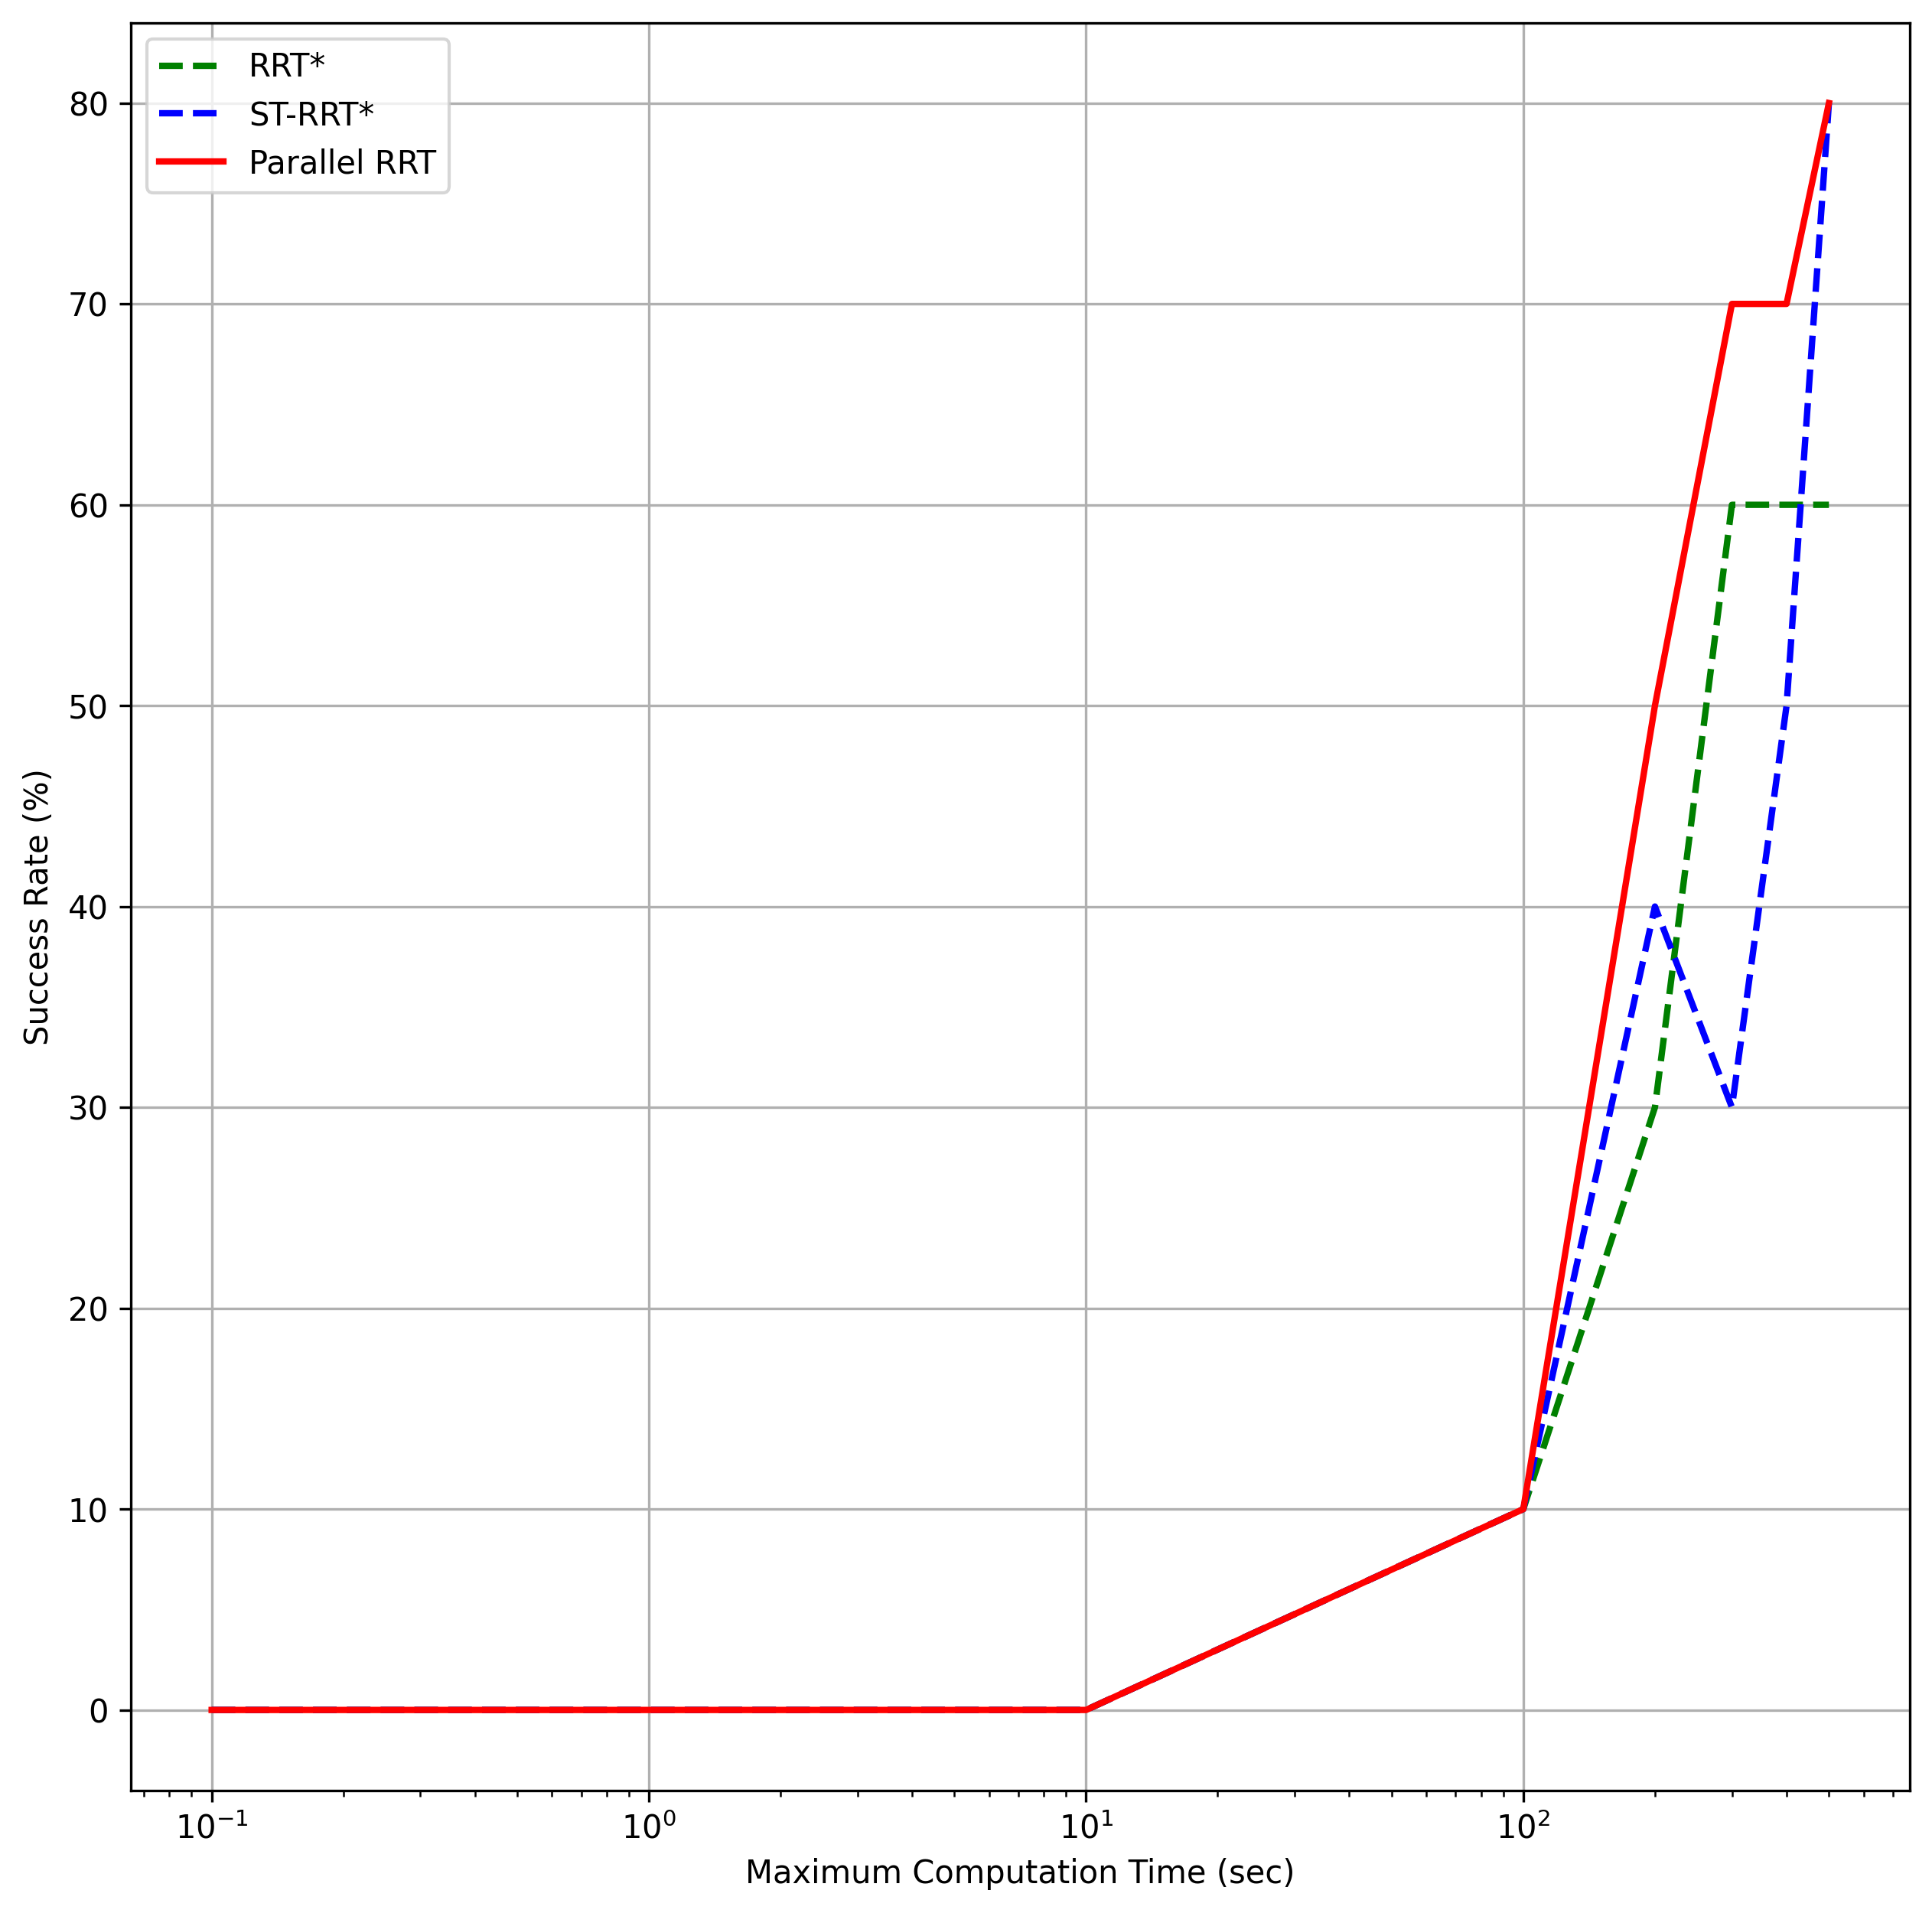

In [ ]:
# Success Rate
successRate_RRTstar_Result = []
successRate_STRRT_Result = []
successRate_RRTP_Result = []
for ii in range(len(list(successRate.keys()))):
    successRate_RRTstar_Result.append(successRate[str(ii)][0]*100)
    successRate_STRRT_Result.append(successRate[str(ii)][1]*100)
    successRate_RRTP_Result.append(successRate[str(ii)][2]*100)

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(1,1,1)
plt.plot(computationTimeLimit_List, successRate_RRTstar_Result, '--g', label='RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, successRate_STRRT_Result, '--b', label='ST-RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, successRate_RRTP_Result, '-r', label='Parallel RRT', linewidth = 2)
plt.legend()
plt.grid()
ax.set_xscale('log')
plt.xlabel('Maximum Computation Time (sec)')
plt.ylabel('Success Rate (%)')
plt.savefig('2DSim_SuccessRate_log.png')

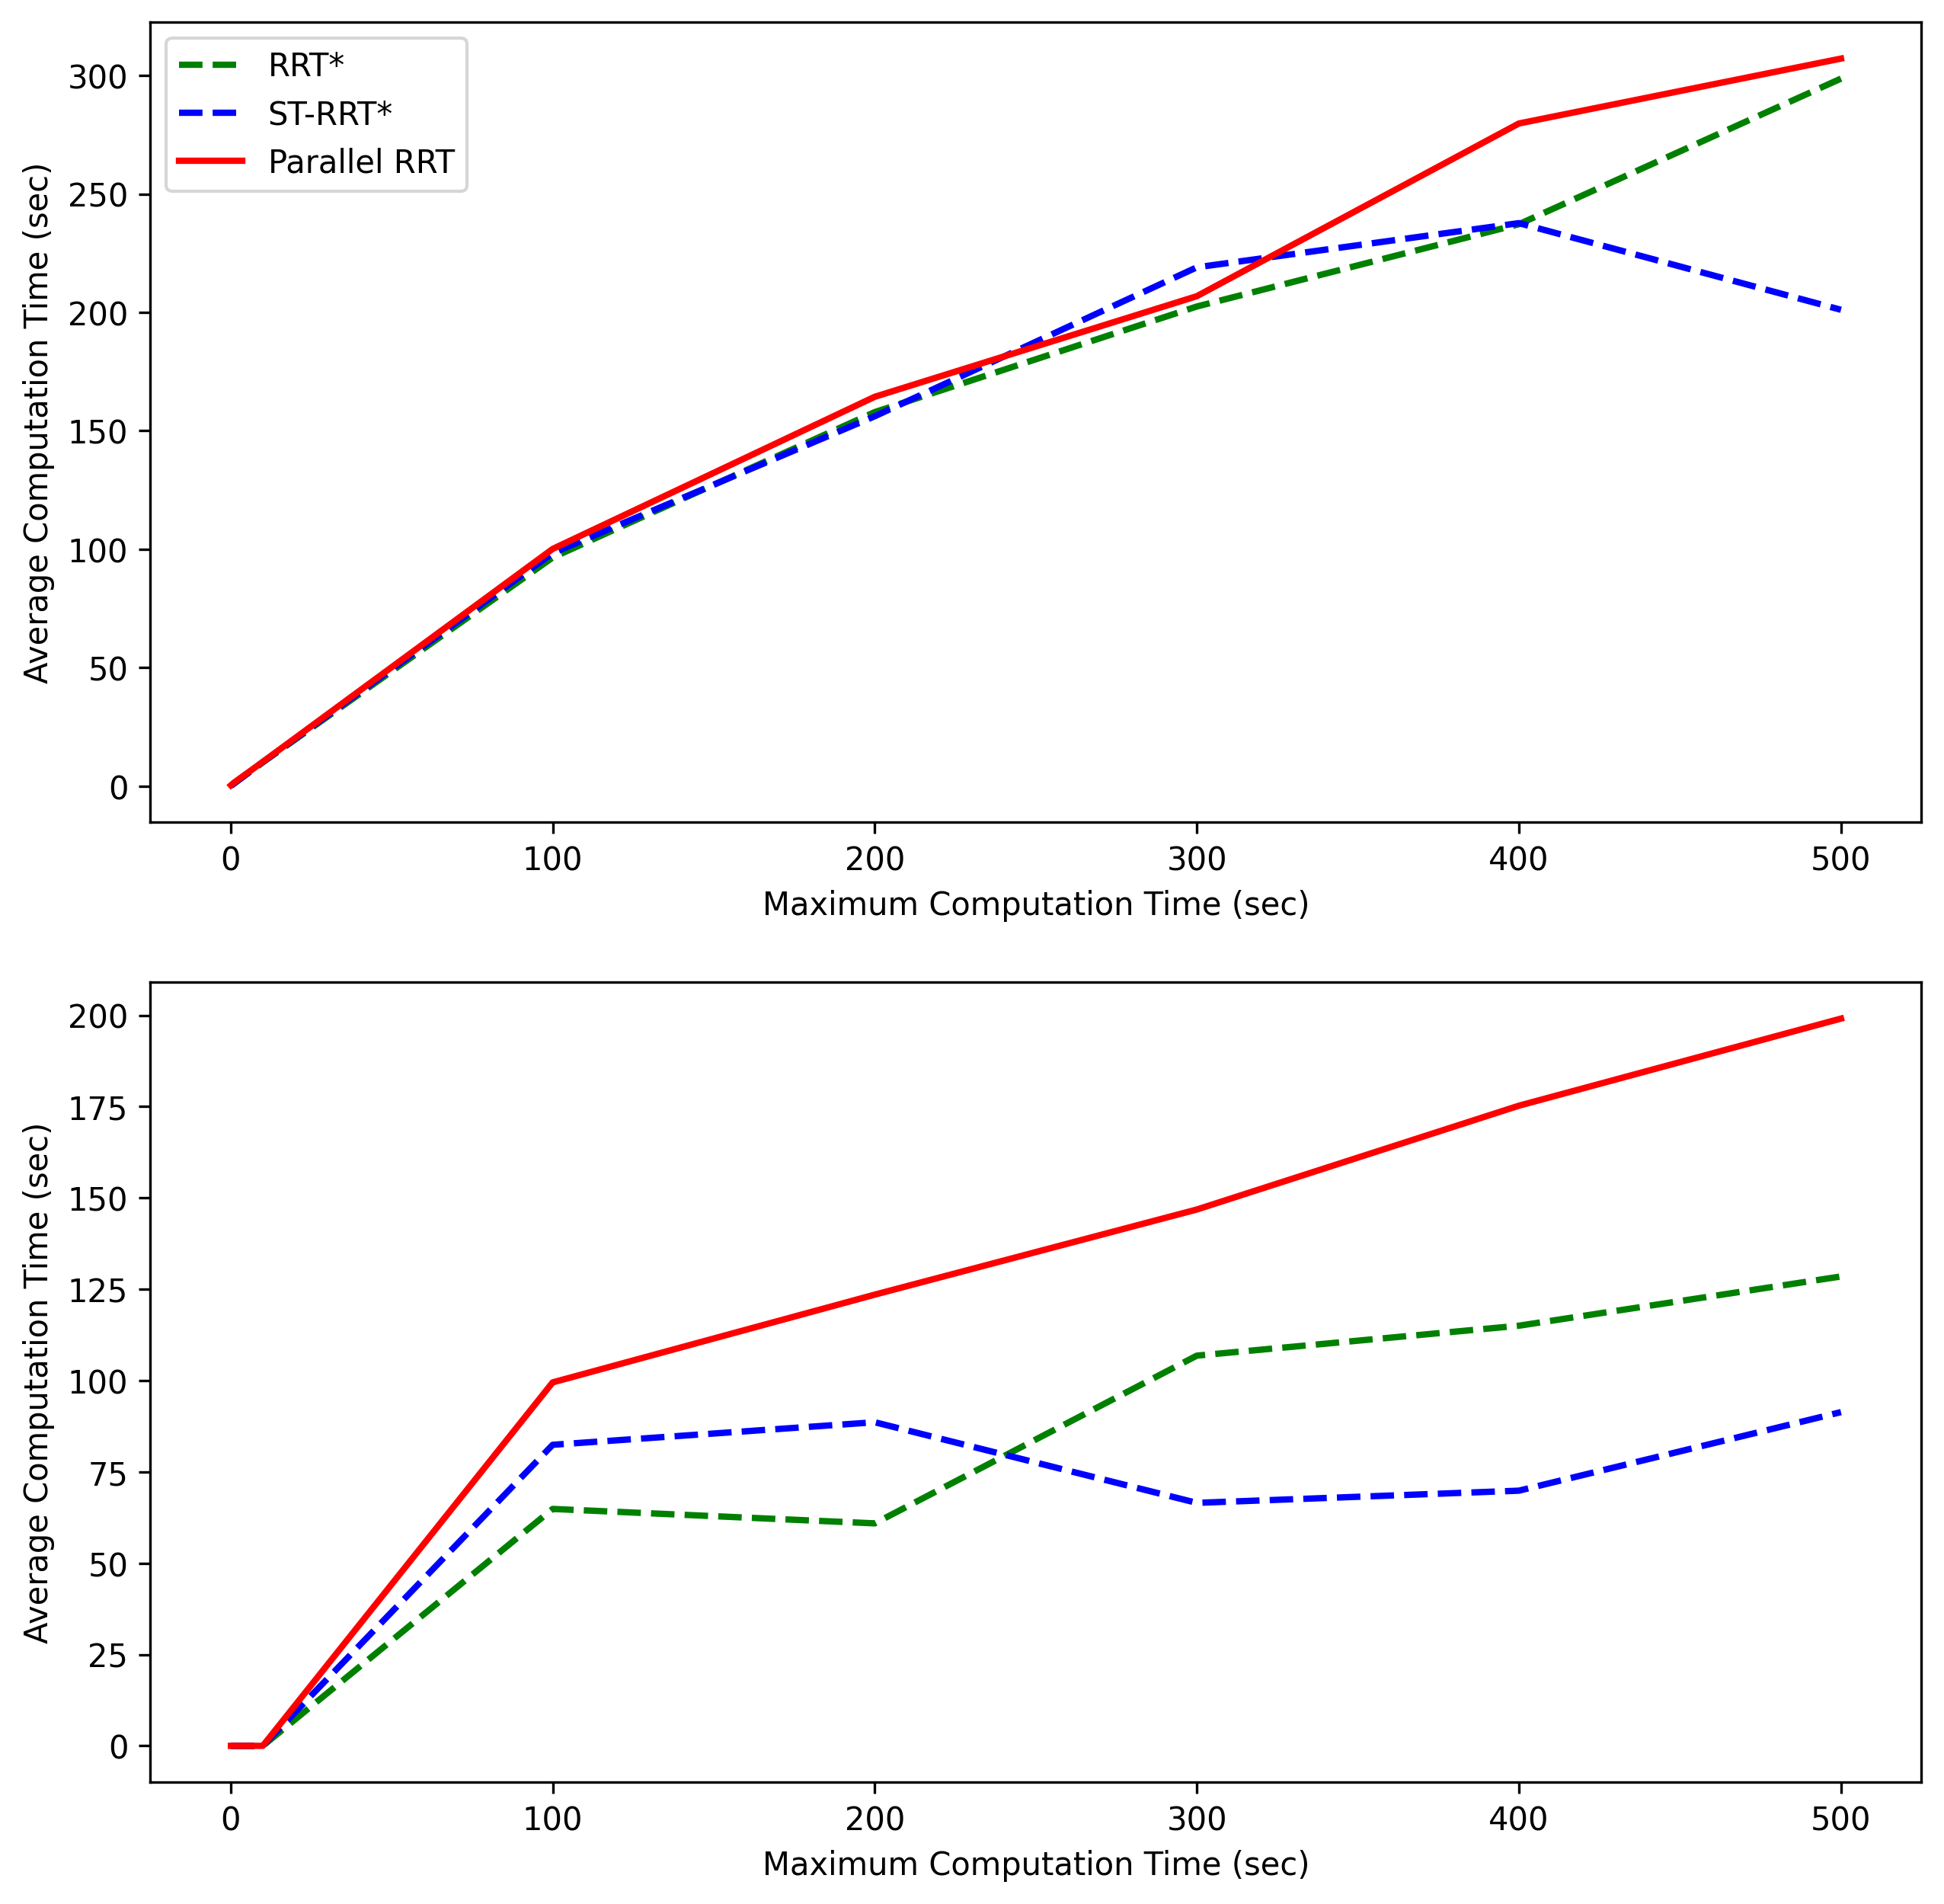

In [ ]:
# Computation Time
compTime_RRTstar_Result = []
compTime_STRRT_Result = []
compTime_RRTP_Result = []
for ii in range(len(list(successRate.keys()))):
    compTime_RRTstar_Result.append(compTime[str(ii)][0])
    compTime_STRRT_Result.append(compTime[str(ii)][1])
    compTime_RRTP_Result.append(compTime[str(ii)][2])

# Computation Time For Success Case
compTimeSuccess_RRTstar_Result = []
compTimeSuccess_STRRT_Result = []
compTimeSuccess_RRTP_Result = []
for ii in range(len(list(successRate.keys()))):
    compTimeSuccess_RRTstar_Result.append(compTimeSuccess[str(ii)][0])
    compTimeSuccess_STRRT_Result.append(compTimeSuccess[str(ii)][1])
    compTimeSuccess_RRTP_Result.append(compTimeSuccess[str(ii)][2])

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(2,1,1)
plt.plot(computationTimeLimit_List, compTime_RRTstar_Result, '--g', label='RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, compTime_STRRT_Result, '--b', label='ST-RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, compTime_RRTP_Result, '-r', label='Parallel RRT', linewidth = 2)
plt.xlabel('Maximum Computation Time (sec)')
plt.ylabel('Average Computation Time (sec)')
plt.legend()
ax = plt.subplot(2,1,2)
plt.plot(computationTimeLimit_List, compTimeSuccess_RRTstar_Result, '--g', linewidth = 2)
plt.plot(computationTimeLimit_List, compTimeSuccess_STRRT_Result, '--b', linewidth = 2)
plt.plot(computationTimeLimit_List, compTimeSuccess_RRTP_Result, '-r', linewidth = 2)
plt.xlabel('Maximum Computation Time (sec)')
plt.ylabel('Average Computation Time (sec)')
plt.savefig('2DSim_ComputationTime.png')

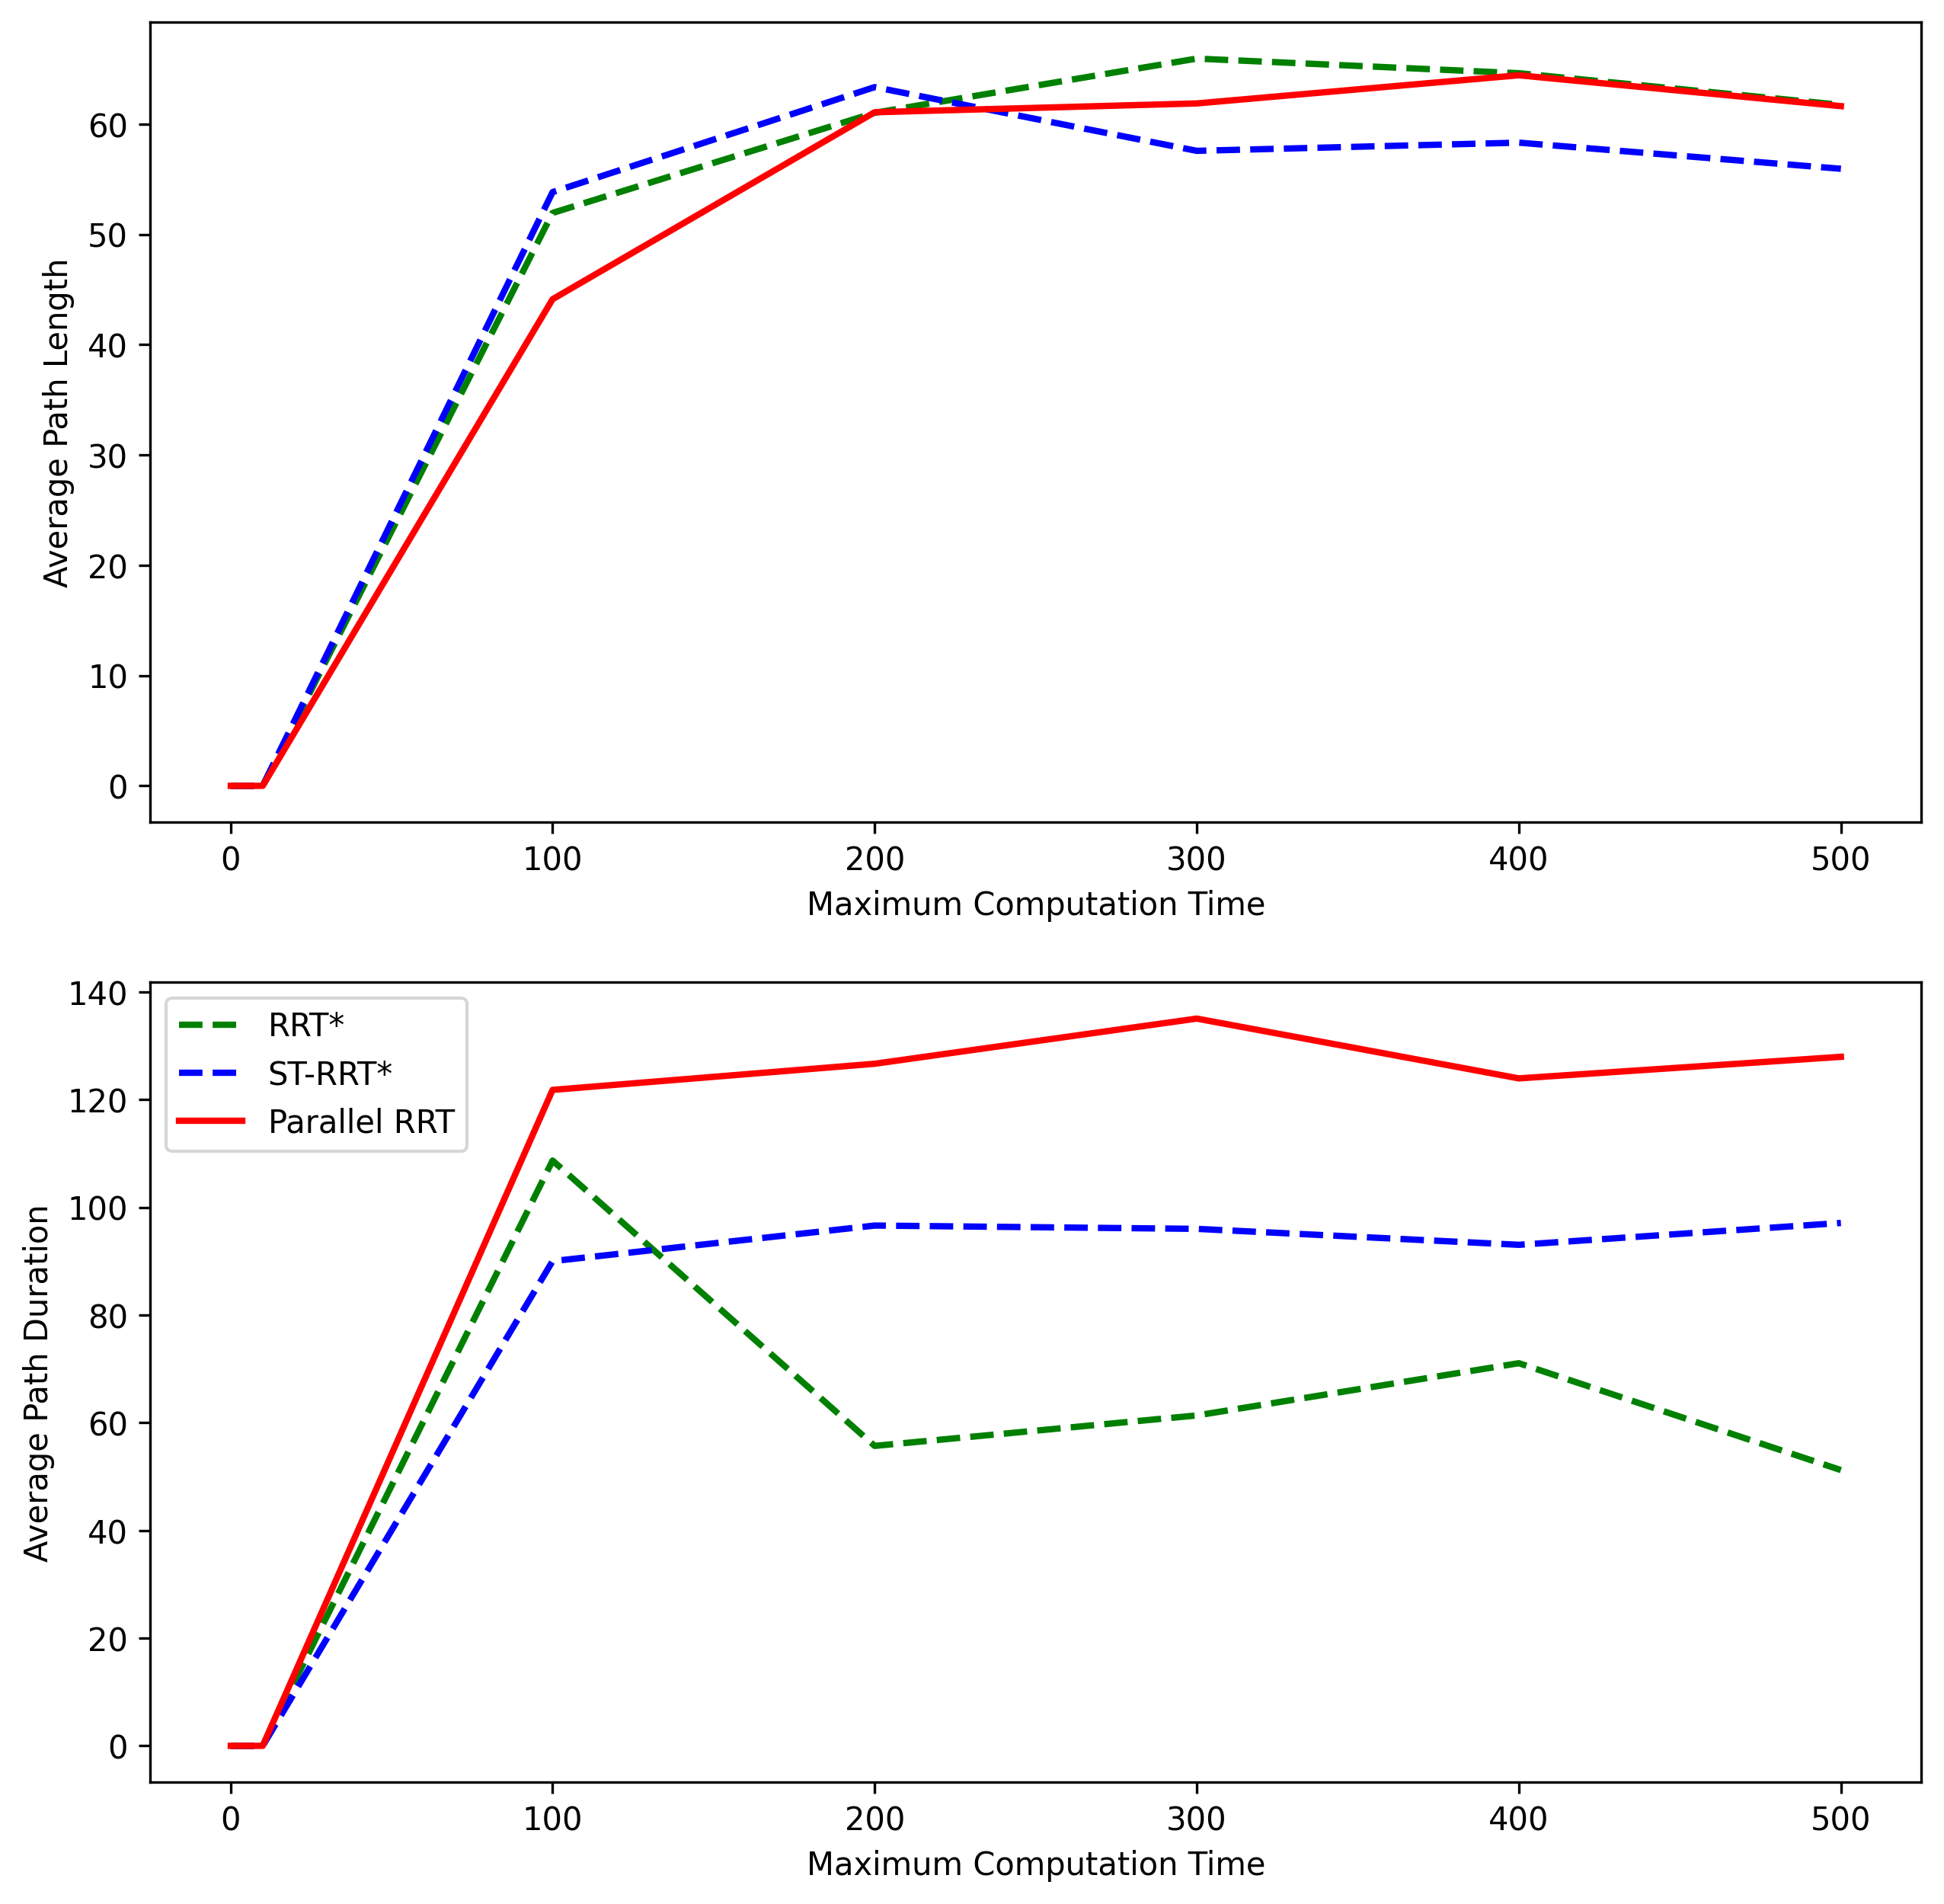

In [ ]:
# Computation Time
pathDist_RRTstar_Result = []
pathDist_STRRT_Result = []
pathDist_RRTP_Result = []
for ii in range(len(list(successRate.keys()))):
    pathDist_RRTstar_Result.append(pathDist[str(ii)][0])
    pathDist_STRRT_Result.append(pathDist[str(ii)][1])
    pathDist_RRTP_Result.append(pathDist[str(ii)][2])

# Computation Time For Success Case
pathTime_RRTstar_Result = []
pathTime_STRRT_Result = []
pathTime_RRTP_Result = []
for ii in range(len(list(successRate.keys()))):
    pathTime_RRTstar_Result.append(np.abs(pathTime[str(ii)][0]))
    pathTime_STRRT_Result.append(pathTime[str(ii)][1])
    pathTime_RRTP_Result.append(pathTime[str(ii)][2])

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = plt.subplot(2,1,1)
plt.plot(computationTimeLimit_List, pathDist_RRTstar_Result, '--g', label='RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, pathDist_STRRT_Result, '--b', label='ST-RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, pathDist_RRTP_Result, '-r', label='Parallel RRT', linewidth = 2)
plt.xlabel('Maximum Computation Time')
plt.ylabel('Average Path Length')
ax = plt.subplot(2,1,2)
plt.plot(computationTimeLimit_List, pathTime_RRTstar_Result, '--g', label='RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, pathTime_STRRT_Result, '--b', label='ST-RRT*', linewidth = 2)
plt.plot(computationTimeLimit_List, pathTime_RRTP_Result, '-r', label='Parallel RRT', linewidth = 2)
plt.legend()
plt.xlabel('Maximum Computation Time')
plt.ylabel('Average Path Duration')
plt.savefig('2DSim_PathCost.png')

In [ ]:
from scipy.spatial import KDTree

start = time.time()
data= np.random.rand(5,3)
sample= np.random.rand(1,3)
kdtree=KDTree(data)
dist,points=kdtree.query(sample,10)
end = time.time()
print(dist, points)
print(time.time()-start)

[[0.53584913 0.62003279 0.81499459 0.88677462 1.01277197        inf
         inf        inf        inf        inf]] [[0 1 3 2 4 5 5 5 5 5]]
0.0011143684387207031
